### Detector Systematics 
- Load the DetVar samples, applies the nue selection on them
- The after selection pickl is used to study the variations

-- efficieny at different stages

-- in function of a variable (plot)

In [1]:
import nue_selection_helper as nue_helper
from helpers import helpfunction as helper
from helpers import plot_class as plotter
from helpers import detvar
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from labellines import labelLine, labelLines
from matplotlib.patches import Rectangle
import pickle

In [2]:
# Matplotlib help
plt.rcParams.update({"axes.titlesize": "medium"})
plt_h = 4.65

def get_fig(ncols, nleg):
    fig, ax = plt.subplots(
        ncols=ncols,
        nrows=2,
        figsize=(3.5 * ncols + 2 * nleg, plt_h),
        gridspec_kw={"height_ratios": [3, 1]},
        constrained_layout=True,
    )
    return fig, ax

In [3]:
write_pickle = False
outfile = './input/July2020/lite/sys_after_training.pckl'
detvar_file = "./input/July2020/lite/detvar_dict.pckl"
input_dir = "./input/July2020/syst/"
output_dir = "./output/nue/syst/"
pot = 5.5e19
str_title = "MicroBooNE 5,5e19$\,$POT, Preliminary"

nu_cats = [2,21]
nue_cats = [1,10,11]
signal_cats = nu_cats

In [4]:
samples = ['_'.join(f.split('/')[-1].split('.')[0].split('_')[:-1]) for f in glob.glob(input_dir+'*.pckl')]

In [5]:
if write_pickle:
    nue_helper.CreateAfterTraining(samples, input_dir, one_file=outfile)
data = pd.read_pickle(outfile)

In [6]:
# We grouped by 'event' was this a smart choice?
for sample in samples:
    print(sample)
    assert len(np.unique(data[sample]['daughters'].xs(0, level='daughter').index)) == len(data[sample]['daughters'].xs(0, level='daughter').index)
    data[sample]['daughters']['filter'] = np.repeat(data[sample]['mc']['filter'], data[sample]['mc']['n_pfps'])

ncpi0_LYRayleigh
ncpi0_LYDown
ccpi0_CV
ccpi0_WireModScaleYZ
nu_LYDown
ncpi0_WireModAngleYZ
nue_LYRayleigh
ccpi0_WireModScaleX
nu_WireModScaledEdX
nue_Recomb2
ncpi0_WireModScaledEdX
nue_LYDown
ccpi0_WireModAngleXZ
nu_WireModScaleYZ
ncpi0_WireModScaleX
nue_LYAttenuation
nue_WireModScaledEdX
nue_WireModScaleX
ncpi0_WireModScaleYZ
ncpi0_SCE
nu_SCE
ccpi0_SCE
nu_WireModAngleYZ
ccpi0_WireModScaledEdX
ccpi0_LYDown
nu_WireModAngleXZ
ccpi0_LYRayleigh
nue_SCE
ccpi0_WireModAngleYZ
nu_WireModScaleX
nue_WireModAngleXZ
ncpi0_CV
nu_CV
nue_WireModScaleYZ
nue_WireModAngleYZ
nu_LYRayleigh
nue_CV


In [7]:
labels = np.array([s.split('_')[1] for s in samples if 'nue' in s])
nuid = np.zeros((len(labels),2))
sel = np.zeros((len(labels),2))

nu_cats = [2,21]
nue_cats = [1,10,11]

for i,label in enumerate(labels):
    sample = 'nue_'+label
    # data[sample]['daughters']['nueccinc_new'] = data[sample]['daughters']['category'].isin(signal) -> validation
    num_w_nuid = data[sample]['mc']['weightSplineTimesTune'][(data[sample]['mc']['nueccinc']) & (data[sample]['mc']['n_pfps']>0)]
    num_w_sel = data[sample]['daughters'].eval('nueccinc*weightSplineTimesTune*select')# .xs(0, level='daughter') -> redundant, select is only one per event
    den_w = data[sample]['mc']['weightSplineTimesTune'][data[sample]['mc']['nueccinc']]
    temp_eff = helper.effErr(num_w_nuid, den_w)
    nuid[i] = temp_eff
    print('{:<30}\t NeutrinoID: {:0.1%}+-{:0.2%}'.format(sample, *temp_eff ))
    den_w_sel = data[sample]['mc']['weightSplineTimesTune'][data[sample]['mc']['nueccinc']]
    temp_eff = helper.effErr(num_w_sel, den_w)
    sel[i] = temp_eff
    print('{:<30}\t Selection: {:0.1%}+-{:0.2%}'.format(sample, *temp_eff ))

nue_LYRayleigh                	 NeutrinoID: 84.0%+-0.14%
nue_LYRayleigh                	 Selection: 18.1%+-0.13%
nue_Recomb2                   	 NeutrinoID: 84.6%+-0.11%
nue_Recomb2                   	 Selection: 18.3%+-0.11%
nue_LYDown                    	 NeutrinoID: 84.8%+-0.11%
nue_LYDown                    	 Selection: 18.3%+-0.11%
nue_LYAttenuation             	 NeutrinoID: 83.9%+-0.14%
nue_LYAttenuation             	 Selection: 17.7%+-0.13%
nue_WireModScaledEdX          	 NeutrinoID: 83.9%+-0.11%
nue_WireModScaledEdX          	 Selection: 17.9%+-0.10%
nue_WireModScaleX             	 NeutrinoID: 84.1%+-0.11%
nue_WireModScaleX             	 Selection: 18.3%+-0.11%
nue_SCE                       	 NeutrinoID: 84.1%+-0.15%
nue_SCE                       	 Selection: 18.2%+-0.14%
nue_WireModAngleXZ            	 NeutrinoID: 84.2%+-0.11%
nue_WireModAngleXZ            	 Selection: 18.3%+-0.11%
nue_WireModScaleYZ            	 NeutrinoID: 84.1%+-0.11%
nue_WireModScaleYZ            	 Selecti

Text(0.5, 1.0, '$\\nu_e$ CC Efficiency')

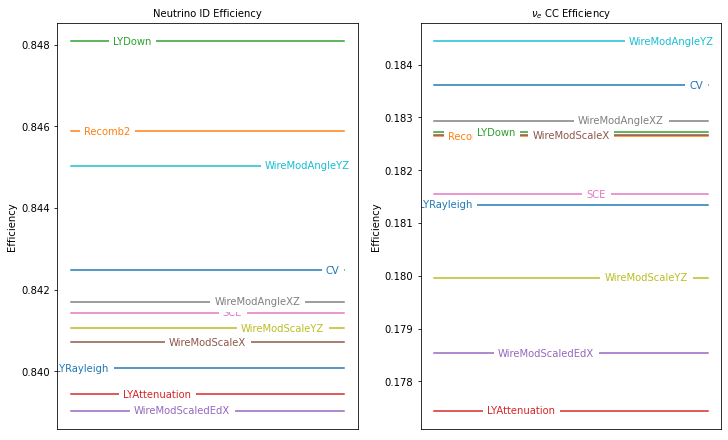

In [8]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,6))

for nuid_i, sel_i, lab_i in zip(nuid, sel, labels):
    ax[0].plot([0,1],[nuid_i[0],nuid_i[0]],label=lab_i)
    ax[1].plot([0,1],[sel_i[0],sel_i[0]],label=lab_i)

labelLines(ax[0].get_lines())
labelLines(ax[1].get_lines())
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_ylabel('Efficiency')
ax[1].set_ylabel('Efficiency')
ax[0].set_title('Neutrino ID Efficiency')
ax[1].set_title(r'$\nu_e$ CC Efficiency')

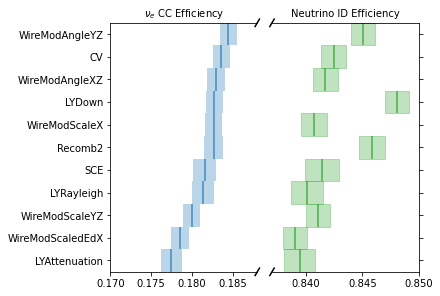

In [9]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(6,4), sharey=True)
sort_idx = np.argsort(sel[:,0])

ax[0].set_ylim(0,len(labels))
ax[0].set_yticks(np.array(range(len(labels)))+0.5)
ax[0].set_yticklabels(labels[sort_idx])
ax[0].set_xlim(0.17,0.188)
ax[1].set_xlim(0.837,0.85)
ax[1].set_title('Neutrino ID Efficiency')
ax[0].set_title(r'$\nu_e$ CC Efficiency')

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.tick_right()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)        # top-left diagonal
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1].plot((-d, +d), (-d, +d), **kwargs)  # bottom-right diagonal

for i,idx in enumerate(sort_idx):
    lab_i = labels[idx]
    nuid_i = nuid[idx]
    sel_i = sel[idx]
    rect = Rectangle((sel_i[0] - sel_i[1], i), 2*sel_i[1], 1, alpha = 0.3)
    ax[0].vlines(x=sel_i[0], ymin=i, ymax=i+1, color='C0', alpha=0.8)
    ax[0].add_patch(rect)
    rect = Rectangle((nuid_i[0] - nuid_i[1], i), 2*nuid_i[1], 1, alpha = 0.3, color='C2')
    ax[1].vlines(x=nuid_i[0], ymin=i, ymax=i+1, color='C2', alpha=0.8)
    ax[1].add_patch(rect)
    
fig.savefig(output_dir+'efficiency.pdf')

In [10]:
plot_list = [
    [
        "shr_dist_v",
        "Shower vertex distance [cm]",
        20,
        0,
        10,
        "e_candidate>0 & preselect",
    ],
    [
        "shr_tkfit_dedx_y_v",
        r"Shower d$E$/d$x$ [MeV/cm]",
        20,
        0,
        10,
        "e_candidate>0 & preselect",
    ],
    ["score", r"Electron PID score", 20, 0, 1, "e_candidate>0 & preselect",],
    [
        "shr_energy_y_v/1000",
        "Electron shower energy [GeV]",
        12,
        0.1,
        2.5,
        "(select & e_candidate)",
    ],
    [
        "shr_theta_v",
        r"Reconstructed electron $\theta$",
        12,
        0.0,
        np.pi,
        "(select & e_candidate)",
    ],
    [
        "trk_at_vtx",
        r"Track multiplicity at vertex",
        12,
        -0.5,
        5.5,
        "(select & e_candidate)",
    ],
]

In [11]:
file = open(detvar_file, "rb")
detvar_dict = pickle.load(file)
file.close()

print('Number of keys in detvar_dict:',len(detvar_dict.keys()))
counter=0

for (field, query, x_min, x_max, N_bins) in detvar_dict.keys():
    counter+=1
    if len(detvar_dict[(field, query, x_min, x_max, N_bins)])==0:
        detvar_dict[(field, query, x_min, x_max, N_bins)] = detvar.get_syt_var(field, query, x_min, x_max, N_bins, data, 1e21)
        print(counter, 'Variable, query:',field,query, detvar_dict[(field, query, x_min, x_max, N_bins)])

file = open(detvar_file, "wb")
pickle.dump(detvar_dict, file)
file.close() 


cks e_candidate>0 & select & (slpdg==12)& optical_filter & (reco_e>0.9) [2.4305928  7.36224277 2.91652152 1.33635834 3.54884244 1.6593743
 0.35432442]
Odd number of bins greater than 6 is not supported! 11
43 Variable, query: n_tracks+n_showers e_candidate>0 & select & (slpdg==12)& optical_filter & (reco_e>0.9) [1.83509934 4.68826781 3.06777764 4.03400448 1.69805707 2.74552005
 1.21571125 0.65100367 0.58826321 0.38961446 0.25062868]
44 Variable, query: ismerged e_candidate>0 & select & (slpdg==12)& optical_filter & (reco_e>0.9) [ 1.64812255 11.48627501]
45 Variable, query: merge_bestdot e_candidate>0 & select & (slpdg==12)& optical_filter & (reco_e>0.9) [1.55813712 1.6630971  0.912005   0.7837392  0.41732538 0.5351578
 2.04395313 1.01981597 1.49114109 1.82152871 1.91313597 3.2747254 ]
46 Variable, query: merge_bestdist e_candidate>0 & select & (slpdg==12)& optical_filter & (reco_e>0.9) [6.06282854 1.11306798 0.59424879 1.30777032 0.73479361 0.67065325
 0.34844369 0.3320354  0.29294467 

In [12]:
fig1, ax1 = get_fig(3, 1)
fig2, ax2 = get_fig(3, 1)
ax = np.hstack([ax1,ax2])

for i, (field, xlabel, N_bins_old, x_min, x_max, query) in enumerate(plot_list):
    print(xlabel)
    N_bins = get_new_n_bins(N_bins_old,max_bin_syst)
    plot_data = []
    plot_weights = []
    bin_err = []
    accepted_labels = []

    for lab in labels:
        nu_sample = 'nu_'+lab
        nue_sample  = 'nue_'+lab
        cc_sample = 'ccpi0_'+lab
        nc_sample = 'ncpi0_'+lab
        if nc_sample not in data:
            #print('skip this vatiation:', lab)
            continue
        if lab=='CV':
            cv_index = len(plot_data)
        accepted_labels.append(lab)

        nu_view = data[nu_sample]['daughters'].query(query)
        nue_view = data[nue_sample]['daughters'].query(query)
        cc_view = data[cc_sample]['daughters'].query(query)
        nc_view = data[nc_sample]['daughters'].query(query)
        views = [nu_view,nue_view,cc_view,nc_view]
        plot_data.append(np.hstack([v.eval(field) for v in views]))

        pot_nu = sum(data[nu_sample]['pot'].values())
        pot_nue = sum(data[nue_sample]['pot'].values()) + pot_nu
        pot_nc = sum(data[nc_sample]['pot'].values()) + pot_nu
        pot_cc = sum(data[cc_sample]['pot'].values()) + pot_nu
        pot_scale_nu = pot/pot_nu
        pot_scale_nue = pot/pot_nue
        pot_scale_nc = pot/pot_nc
        pot_scale_cc = pot/pot_cc

        filter_array = np.hstack([v['filter'] for v in views])
        filter_mask = np.zeros(len(plot_data[-1]))
        for filter_type, pot_scale in zip([4,62,72], [pot_scale_nue, pot_scale_cc, pot_scale_nc]):
            filter_mask += (filter_array==filter_type)*pot_scale
        plot_weights_mixed = np.hstack([v['weightSplineTimesTune'] for v in views])
        plot_weights_mixed = np.where(filter_mask, plot_weights_mixed*filter_mask, plot_weights_mixed*0) #*pot_scale_nu)
        plot_weights.append(plot_weights_mixed)

        edges = np.linspace(x_min,x_max,N_bins+1)
        bin_err.append(plotter.hist_bin_uncertainty(plot_data[-1], plot_weights[-1], x_min, x_max, edges))

    edges, edges_mid, bins, max_val = plotter.histHelper(N_bins, x_min, x_max, plot_data, weights=plot_weights)
    bins_cv = bins[cv_index]
    widths = edges_mid - edges[:-1]

    for j,lab in enumerate(accepted_labels):
        lower = bins[j]-bin_err[j]
        upper = bins[j]+bin_err[j]
        ax[0][i].errorbar(
                    edges_mid,
                    bins[j],
                    xerr=widths,
                    yerr=0,
                    alpha=1.0,
                    fmt="none",
                    label=lab
                )
        ax[1][i].errorbar(
                    edges_mid,
                    bins[j] / bins_cv,
                    xerr=widths,
                    yerr=0,
                    alpha=1.0,
                    fmt="none",
                )
        lower = (bins[j]-bin_err[j])/bins_cv
        upper = (bins[j]+bin_err[j])/bins_cv

    ax[1][i].set_xlabel(xlabel)
    ax[0][i].set_title(str_title)
    ax[0][i].set_xlim(x_min,x_max)
    ax[1][i].set_xlim(x_min,x_max)
    ax[0][i].set_ylabel('events/bin')
    ax[1][i].set_ylabel('ratio with CV')

ax[1][4].set_xticks(helper.theta_ticks)
ax[1][4].set_xticklabels(helper.theta_labs)
ax[0][4].set_xticks(helper.theta_ticks)
ax[0][4].set_xticklabels(helper.theta_labs)

ax[0][2].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")
ax[0][5].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

fig1.savefig(output_dir+'preselection.pdf')
fig2.savefig(output_dir+'selection.pdf')

Shower vertex distance [cm]


NameError: name 'get_new_n_bins' is not defined

In [13]:
labels

array(['LYRayleigh', 'Recomb2', 'LYDown', 'LYAttenuation',
       'WireModScaledEdX', 'WireModScaleX', 'SCE', 'WireModAngleXZ',
       'WireModScaleYZ', 'WireModAngleYZ', 'CV'], dtype='<U16')

In [14]:
for plot_lab in accepted_labels:
    if plot_lab=='CV':
        continue
    print(lab)
    fig1, ax1 = get_fig(3, 1)
    fig2, ax2 = get_fig(3, 1)
    ax = np.hstack([ax1,ax2])

    for i, (field, xlabel, N_bins_old, x_min, x_max, query) in enumerate(plot_list):
        print(xlabel)
        N_bins = get_new_n_bins(N_bins_old,max_bin_syst)
        plot_data = []
        plot_weights = []
        bin_err = []

        for lab in ['CV', plot_lab]:
            nu_sample = 'nu_'+lab
            nue_sample  = 'nue_'+lab
            cc_sample = 'ccpi0_'+lab
            nc_sample = 'ncpi0_'+lab

            nu_view = data[nu_sample]['daughters'].query(query)
            nue_view = data[nue_sample]['daughters'].query(query)
            cc_view = data[cc_sample]['daughters'].query(query)
            nc_view = data[nc_sample]['daughters'].query(query)
            views = [nu_view,nue_view,cc_view,nc_view]
            plot_data.append(np.hstack([v.eval(field) for v in views]))

            pot_nu = sum(data[nu_sample]['pot'].values())
            pot_nue = sum(data[nue_sample]['pot'].values()) + pot_nu
            pot_nc = sum(data[nc_sample]['pot'].values()) + pot_nu
            pot_cc = sum(data[cc_sample]['pot'].values()) + pot_nu
            pot_scale_nu = pot/pot_nu
            pot_scale_nue = pot/pot_nue
            pot_scale_nc = pot/pot_nc
            pot_scale_cc = pot/pot_cc

            filter_array = np.hstack([v['filter'] for v in views])
            filter_mask = np.zeros(len(plot_data[-1]))
            for filter_type, pot_scale in zip([4,62,72], [pot_scale_nue, pot_scale_cc, pot_scale_nc]):
                filter_mask += (filter_array==filter_type)*pot_scale
            plot_weights_mixed = np.hstack([v['weightSplineTimesTune'] for v in views])
            plot_weights_mixed = np.where(filter_mask, plot_weights_mixed*filter_mask, plot_weights_mixed*0)#pot_scale_nu)
            plot_weights.append(plot_weights_mixed)
            edges = np.linspace(x_min,x_max,N_bins+1)
            bin_err.append(plotter.hist_bin_uncertainty(plot_data[-1], plot_weights[-1], x_min, x_max, edges))

        edges, edges_mid, bins, max_val = plotter.histHelper(N_bins, x_min, x_max, plot_data, weights=plot_weights)
        bins_cv = bins[0]
        widths = edges_mid - edges[:-1]

        for j,lab in enumerate(['CV', plot_lab]):
            lower = bins[j]-bin_err[j]
            upper = bins[j]+bin_err[j]
            ax[0][i].errorbar(
                        edges_mid,
                        bins[j],
                        xerr=widths,
                        yerr=0,
                        alpha=1.0,
                        fmt="none",
                        label=lab
                    )
            ax[0][i].fill_between(edges, np.append(lower,lower[-1]), np.append(upper,lower[-1]), step='post', alpha=0.3)
            ax[1][i].errorbar(
                        edges_mid,
                        bins[j] / bins_cv,
                        xerr=widths,
                        yerr=0,
                        alpha=1.0,
                        fmt="none",
                    )
            lower = (bins[j]-bin_err[j])/bins_cv
            upper = (bins[j]+bin_err[j])/bins_cv
            ax[1][i].fill_between(edges, np.append(lower,lower[-1]), np.append(upper,lower[-1]), step='post', alpha=0.3)

        ax[1][i].set_xlabel(xlabel)
        ax[0][i].set_title(str_title)
        ax[0][i].set_xlim(x_min,x_max)
        ax[1][i].set_xlim(x_min,x_max)
        ax[0][i].set_ylabel('events/bin')
        ax[1][i].set_ylabel('ratio with CV')

    ax[1][4].set_xticks(helper.theta_ticks)
    ax[1][4].set_xticklabels(helper.theta_labs)
    ax[0][4].set_xticks(helper.theta_ticks)
    ax[0][4].set_xticklabels(helper.theta_labs)

    ax[0][2].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")
    ax[0][5].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

    fig1.savefig(output_dir+'preselection_{}.pdf'.format(plot_lab))
    fig2.savefig(output_dir+'selection_{}.pdf'.format(plot_lab))

NameError: name 'accepted_labels' is not defined